In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
INPUT_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL"
OUTPUT_DIR = "/kaggle/working/weak_masks"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
def generate_weak_mask_cxr(img_path):
    # 1. carregar
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    img = cv2.resize(img, (512, 512))
    
    # 2. Torna branco tudo que estiver fora do intervalo [50, 180] 
    # para facilitar a geração de uma boa máscara
    img[img < 50] = 255 
    img[img > 180] = 255
    
    # 3. equalização + suavização
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    I = clahe.apply(img)
    I = cv2.GaussianBlur(I, (7,7), 0)
    
    for ang in np.arange(0, 151, 30):
        se = np.zeros((15, 15), np.uint8)
        cv2.ellipse(se, (15//2, 15//2), (15//2, 1), ang, 0, 360, 1, -1)
        I_supp = cv2.morphologyEx(I, cv2.MORPH_OPEN, se)
        I = cv2.min(I, I_supp)
        
    # 4. inverter para que opacidades fiquem claras
    I_inv = cv2.normalize(255 - I, None, 0, 255, cv2.NORM_MINMAX)

    # 5. opções de threshold (escolha uma)
    _, bw = cv2.threshold(I_inv, 127, 255, cv2.THRESH_BINARY)
    
    # 6. limpar regiões fora dos pulmões
    # remove um pequeno pedaço do topo e das laterais que não incluem o pulmão (geralmente)
    bw[:40, :], bw[:, -70:], bw[:, :70] = 0,0, 0
    
    # 7. morfologia para suavizar
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
    
    # 8. manter regiões internas
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bw)
    mask_out = np.zeros_like(bw)
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        x,y = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP]
        wc,hc = stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]

        # descarta regiões no topo e muito pequenas
        if area > 500 and y > 39:
            mask_out[labels == i] = 255
    
    # 9. voltar ao tamanho original
    mask_out = cv2.resize(mask_out, (w, h))
    return (mask_out > 0).astype(np.uint8)

In [4]:
# Gera máscaras binárias de 0 ou 255.
for filename in tqdm(os.listdir(INPUT_DIR)):
    # if filename.lower().endswith(".png":
        img_path = os.path.join(INPUT_DIR, filename)
        mask = generate_weak_mask_cxr(img_path)
        cv2.imwrite(os.path.join(OUTPUT_DIR, filename.rsplit(".",1)[0] + ".png"), (mask*255))

100%|██████████| 234/234 [00:09<00:00, 25.31it/s]


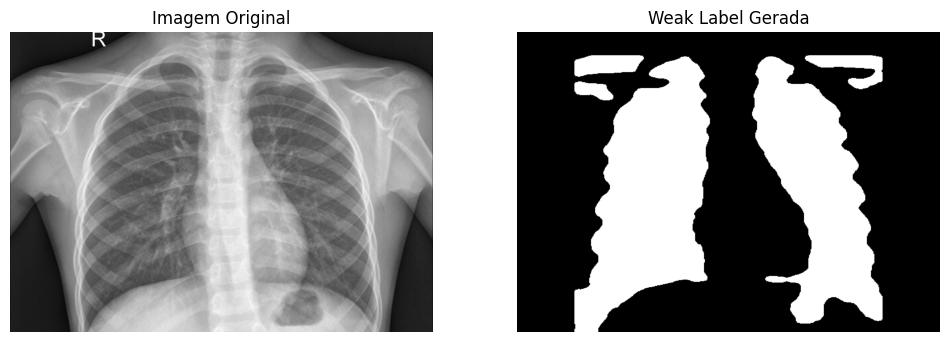

In [6]:
sample = "IM-0001-0001.jpeg"

img = cv2.imread(os.path.join(INPUT_DIR, sample), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(os.path.join(OUTPUT_DIR, sample.rsplit(".",1)[0] + ".png"), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Imagem Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Weak Label Gerada")
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

### Usando UNet com ativação Sigmóide para treinar as Weak Labels

In [9]:
!pip install segmentation-models-pytorch
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.4 MB/s eta 0:00:0000:0100:01m
  Attempting uninst

In [10]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",       # backbone
    encoder_weights="imagenet",     # opcional
    in_channels=1,                  # suas radiografias são 1 canal
    classes=1,                      # saída de 1 canal
    activation="sigmoid"            # exatamente como você quer
)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [11]:
# Função de perda Soft Dice Loss
loss = smp.losses.DiceLoss(mode="binary")

In [ ]:
import torch
from torch.utils.data import DataLoader

# Aqui tem que criar o dataset para depois usar o train_loader

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Treinamento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

for epoch in range(20):
    model.train()
    total = 0
    
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        preds = model(imgs)            # já sai com sigmoide
        loss_value = loss(preds, masks)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        total += loss_value.item()

    print(f"Epoch {epoch+1}: loss = {total / len(train_loader):.4f}")